In [1]:
pip install pysindy

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 121 kB 10.7 MB/s eta 0:00:01
     |████████████████████████████████| 10.7 MB 55.4 MB/s eta 0:00:01
     |████████████████████████████████| 24.0 MB 51.0 MB/s eta 0:00:01
     |████████████████████████████████| 9.8 MB 48.2 MB/s eta 0:00:01     |███████████████████▋            | 6.0 MB 48.2 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 51.7 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
polyga 1.0.12 requires rdkit-pypi<2022.0.0,>=2021.3.3, which is not installed.
qmpy 1.4.0 requires Jinja2<3.0, but you have jinja2 3.0.1 which is incompatible.
polyga 1.0.12 requires scipy<2.0,>=1.7, but you have sci

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
from scipy.integrate import solve_ivp
from scipy.io import loadmat
from pysindy.utils import linear_damped_SHO
from pysindy.utils import cubic_damped_SHO
from pysindy.utils import linear_3D
from pysindy.utils import hopf
from pysindy.utils import lorenz

import pysindy as ps

# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(1000)  # Seed for reproducibility

# Integrator keywords for solve_ivp
integrator_keywords = {} #"rtol controls a relative accuracy (number of correct digits), while atol controls absolute accuracy (number of correct decimal places)."
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA' #LSODA: "Adams/BDF method with automatic stiffness detection and switching." "is for solving ordinary differential equation initial value problems."
integrator_keywords['atol'] = 1e-12

In [8]:
dt = 0.01
t_train = np.arange(0, 25, dt)
print(t_train)
t_train_span = (t_train[0], t_train[-1]) #why -1 if arrays start at 0? -> last element in sequence
print(t_train_span)
x0_train = [2, 0]
print(x0_train)

x_train = solve_ivp(linear_damped_SHO, t_train_span, 
                    x0_train, t_eval=t_train, **integrator_keywords).y.T #what is .y for? .T is for transpose.
print(x_train)

[0.000e+00 1.000e-02 2.000e-02 ... 2.497e+01 2.498e+01 2.499e+01]
(0.0, 24.990000000000002)
[2, 0]
[[ 2.          0.        ]
 [ 1.99760141 -0.03995736]
 [ 1.99440741 -0.07981887]
 ...
 [ 0.15601786  0.0526537 ]
 [ 0.1568827   0.04947352]
 [ 0.15768297  0.04627988]]


In [9]:
# Fit the model

poly_order = 5 #why 5th order?
threshold = 0.05

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order),
) #does not include differentiation_methon, is it because its been solved with solve_ivp in cell prior?
model.fit(x_train, t=dt)
model.print()

(x0)' = -0.100 x0 + 2.000 x1
(x1)' = -2.000 x0 + -0.100 x1


In [22]:
#try different models by changing optimizers

print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=5, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=ps.PolynomialLibrary(degree=poly_order), optimizer=optimizer)
model.fit(x_train, t=dt)
model.print()

print('\nSR3 model, L0 norm: ')
optimizer = ps.SR3(threshold=7, max_iter=10000, tol=1e-15, nu=1e2,
                   thresholder='l0', normalize_columns=True)
model = ps.SINDy(feature_library=ps.PolynomialLibrary(degree=poly_order), optimizer=optimizer)
model.fit(x_train, t=dt)
model.print()

print('\nSR3 model, L1 norm: ')
optimizer = ps.SR3(threshold=0.05, max_iter=10000, tol=1e-15,
                   thresholder='l1', normalize_columns=True)
model = ps.SINDy(feature_library=ps.PolynomialLibrary(degree=poly_order), optimizer=optimizer)
model.fit(x_train, t=dt)
model.print()

print('\nSSR model: ')
optimizer = ps.SSR(normalize_columns=True, kappa=5e-3)
model = ps.SINDy(feature_library=ps.PolynomialLibrary(degree=poly_order), optimizer=optimizer)
model.fit(x_train, t=dt)
model.print()

print('\nSSR (metric = model residual) model: ')
optimizer = ps.SSR(criteria='model_residual', normalize_columns=True, kappa=5e-3)
model = ps.SINDy(feature_library=ps.PolynomialLibrary(degree=poly_order), optimizer=optimizer)
model.fit(x_train, t=dt)
model.print()

print('\n FROLs model: ')
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-5)
model = ps.SINDy(feature_library=ps.PolynomialLibrary(degree=poly_order), optimizer=optimizer)
model.fit(x_train, t=dt)
model.print()

STLSQ model: 
(x0)' = 2.005 x1
(x1)' = -1.995 x0

SR3 model, L0 norm: 
(x0)' = 2.005 x1
(x1)' = -1.995 x0

SR3 model, L1 norm: 
(x0)' = -0.100 x0 + 2.000 x1
(x1)' = -2.000 x0 + -0.100 x1

SSR model: 
(x0)' = 2.005 x1
(x1)' = -2.001 x0 + 0.004 x0^3

SSR (metric = model residual) model: 
(x0)' = -0.100 x0 + 2.000 x1
(x1)' = -2.000 x0 + -0.100 x1

 FROLs model: 
(x0)' = -0.100 x0 + 2.000 x1
(x1)' = -2.000 x0 + -0.100 x1


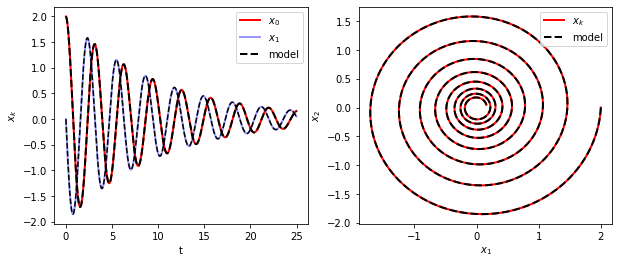

In [10]:
# Simulate and plot the results

x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(t_train, x_train[:, 0], "r", label="$x_0$", **plot_kws)
axs[0].plot(t_train, x_train[:, 1], "b", label="$x_1$", alpha=0.4, **plot_kws)
axs[0].plot(t_train, x_sim[:, 0], "k--", label="model", **plot_kws)
axs[0].plot(t_train, x_sim[:, 1], "k--")
axs[0].legend()
axs[0].set(xlabel="t", ylabel="$x_k$")

axs[1].plot(x_train[:, 0], x_train[:, 1], "r", label="$x_k$", **plot_kws)
axs[1].plot(x_sim[:, 0], x_sim[:, 1], "k--", label="model", **plot_kws)
axs[1].legend()
axs[1].set(xlabel="$x_1$", ylabel="$x_2$")
fig.show()